In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, Matern, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:

thickness_lst = []
wtw_thickness = []
refractive_lst = []
wtw_refractive = []
f = pd.ExcelFile('Data/O3 development.xlsx')

for name in f.sheet_names:
    if name == 'DOE':
        doe = pd.read_excel('Data/O3 development.xlsx', engine='openpyxl',sheet_name = 'DOE')
        doe = doe[doe.columns[-6::]]
        doe.columns = [['Ar (sccm)', 'O3 (sccm)', 'Turn on (s) TMA', 'Turn off (s) TMA','Turn off (s) Ozone','Turn off (s) Ozone']]
        doe = doe[1:]
        doe.index = ['Run{}'.format(x) for x in range(15,23)]
    else:
        cur_sheet = pd.read_excel('Data/O3 development.xlsx', engine='openpyxl',sheet_name = name)
        needed_cols = ['Unnamed: {}'.format(x) for x in range(2,13)]
        thickness = cur_sheet[needed_cols][2:26].reset_index(drop = True)
        thickness.columns = ['SE testing point:{}'.format(x) for x in range(1, 10)]+['Avg', 'WIW']
        thickness_lst.append(thickness)
        
        refractive = cur_sheet[needed_cols][30::].reset_index(drop = True)
        refractive.columns = ['SE testing point:{}'.format(x) for x in range(1, 10)] + ['Avg','WIW']
        refractive_lst.append(refractive)
        
        wtw_thickness.append(cur_sheet['Unnamed: 13'].iloc[2])
        wtw_refractive.append(cur_sheet['Unnamed: 13'].iloc[30])

In [3]:
para = doe.to_numpy()
# rf = np.array(refractive_lst)
rf_wtw = np.array(wtw_refractive)
# tk = np.array(thickness_lst)
tk_wtw = np.array(wtw_thickness)

In [4]:
# choices of length scale upperbound and kernels as a list
length_scale_choices = [1000,100,10,1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
length_scale_choices.reverse()
res = []
NOISE_LEVEL = 1e-5
def produce_kernels_scale(upperbounds,res):
    # upperbounds: a list of float denoting the upperbounds for length scale parameter of kernels
    # res: a list of kernel outputs
    for i in upperbounds:
        
        kernel_choices = [1.0 * RBF(length_scale_bounds=(0,i)) + WhiteKernel(noise_level=NOISE_LEVEL),
                 1.0 * RBF(length_scale_bounds=(0,i)) + WhiteKernel(noise_level=NOISE_LEVEL)+C(),
                 1.0 * Matern(length_scale_bounds=(0,i)) + WhiteKernel(noise_level=NOISE_LEVEL),
                 1.0 * RationalQuadratic(length_scale_bounds=(0,i)) + WhiteKernel(noise_level=NOISE_LEVEL),
                 C() * RBF(length_scale_bounds=(0,i)) + WhiteKernel(noise_level=NOISE_LEVEL),
                 DotProduct()+WhiteKernel(noise_level=NOISE_LEVEL)]

        res.extend(kernel_choices)
    return res

kernel_choices = produce_kernels_scale(length_scale_choices,res)
kernel_choices

[1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05),
 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05) + 1**2,
 1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-05),
 1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-05),
 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05),
 DotProduct(sigma_0=1) + WhiteKernel(noise_level=1e-05),
 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05),
 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05) + 1**2,
 1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-05),
 1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-05),
 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05),
 DotProduct(sigma_0=1) + WhiteKernel(noise_level=1e-05),
 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05),
 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05) + 1**2,
 1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(

In [5]:
### Data setup 
NUM_OF_DATA_POINTS = 20
NUM_OF_PLOT_POINTS = 100
# gp settings 
NOISE_LEVEL = 1e-5

kernel = 1.0 * RBF(length_scale=5) + WhiteKernel(noise_level=NOISE_LEVEL)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)

In [6]:
X = para 
Y = np.array([tk_wtw,rf_wtw]).reshape(8,2)

In [7]:
#### Kernel setting and prediction
#### Taking out one data point and training on the rest, generating len(Y) different models
def model_performance(gp,kernel,X,Y):
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)
    models = cross_validate(gp, X, Y, return_estimator = True,cv=len(Y),scoring="neg_mean_squared_error",return_train_score = True)
    for i in models["estimator"]:
        print("Learned kernel", str(i.kernel_))
    print("\n")
    print("test scores for each model",models['test_score'],"\n")
    print("negative mean squared error",models["train_score"],"\n")
    print("log marginal likelihood", [i.log_marginal_likelihood() for i in models["estimator"]],"\n")
    return models

for i in kernel_choices:
    models = model_performance(gp,i,X,Y)

Learned kernel 0.0298**2 * RBF(length_scale=1e-07) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0367**2 * RBF(length_scale=1e-07) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0392**2 * RBF(length_scale=1e-07) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0406**2 * RBF(length_scale=1e-07) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0423**2 * RBF(length_scale=1e-07) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0424**2 * RBF(length_scale=1e-07) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0424**2 * RBF(length_scale=1e-07) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0424**2 * RBF(length_scale=1e-07) + WhiteKernel(noise_level=1e-05)


test scores for each model [-6.41725331e-03 -3.16230500e-03 -1.83989000e-03 -1.10100500e-03
 -1.00000000e-04 -3.06500000e-05 -1.98650000e-05 -2.12500000e-05] 

negative mean squared error [-1.35025557e-07 -8.88782718e-08 -7.80477845e-08 -7.30725683e-08
 -6.72647189e-08 -6.68963225e-08 -6.68393928e-08 -6.68466983e-08] 

log m

Learned kernel 0.0298**2 * Matern(length_scale=1e-06, nu=1.5) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0367**2 * Matern(length_scale=1e-06, nu=1.5) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0392**2 * Matern(length_scale=1e-06, nu=1.5) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0406**2 * Matern(length_scale=1e-06, nu=1.5) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0423**2 * Matern(length_scale=1e-06, nu=1.5) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0424**2 * Matern(length_scale=1e-06, nu=1.5) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0424**2 * Matern(length_scale=1e-06, nu=1.5) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0424**2 * Matern(length_scale=1e-06, nu=1.5) + WhiteKernel(noise_level=1e-05)


test scores for each model [-6.41725331e-03 -3.16230500e-03 -1.83989000e-03 -1.10100500e-03
 -1.00000000e-04 -3.06500000e-05 -1.98650000e-05 -2.12500000e-05] 

negative mean squared error [-1.35025557e-07 -8.88782718e-08 -7.80477845e-08 -

Learned kernel 0.0298**2 * RBF(length_scale=1e-05) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0367**2 * RBF(length_scale=1e-05) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0392**2 * RBF(length_scale=1e-05) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0406**2 * RBF(length_scale=1e-05) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0423**2 * RBF(length_scale=1e-05) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0424**2 * RBF(length_scale=1e-05) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0424**2 * RBF(length_scale=1e-05) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0424**2 * RBF(length_scale=1e-05) + WhiteKernel(noise_level=1e-05)


test scores for each model [-6.41725331e-03 -3.16230500e-03 -1.83989000e-03 -1.10100500e-03
 -1.00000000e-04 -3.06500000e-05 -1.98650000e-05 -2.12500000e-05] 

negative mean squared error [-1.35025557e-07 -8.88782718e-08 -7.80477845e-08 -7.30725683e-08
 -6.72647189e-08 -6.68963225e-08 -6.68393928e-08 -6.68466983e-08] 

log m

Learned kernel DotProduct(sigma_0=0.00336) + WhiteKernel(noise_level=0.000156)
Learned kernel DotProduct(sigma_0=0.00107) + WhiteKernel(noise_level=6.92e-05)
Learned kernel DotProduct(sigma_0=0.142) + WhiteKernel(noise_level=1e-05)
Learned kernel DotProduct(sigma_0=0.0081) + WhiteKernel(noise_level=0.000156)
Learned kernel DotProduct(sigma_0=0.00626) + WhiteKernel(noise_level=0.000156)
Learned kernel DotProduct(sigma_0=0.03) + WhiteKernel(noise_level=0.000156)


test scores for each model [-3.24263993e-04 -3.42811124e-04 -8.69976176e-05 -1.15463429e-03
 -5.15738822e-03 -1.94137607e-03 -8.35468788e-05 -7.49272559e-05] 

negative mean squared error [-4.29764503e-07 -2.28205345e-06 -2.25186254e-05 -1.00527081e-05
 -3.91038116e-07 -2.25192459e-05 -2.25182990e-05 -2.25183028e-05] 

log marginal likelihood [-42.3037722923393, -41.60115809223011, -43.150289913936504, -41.26719898900778, -39.63469369521211, -40.04403085125753, -43.188528748495585, -43.29812311684591] 

Learned kernel 0.0298**2

Learned kernel 0.0213**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=1.05e-05) + 0.0208**2
Learned kernel 0.0284**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=1.02e-05) + 0.0234**2
Learned kernel 0.0301**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=1.02e-05) + 0.0252**2
Learned kernel 0.0306**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=1.02e-05) + 0.0266**2
Learned kernel 0.0294**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=1.01e-05) + 0.0304**2
Learned kernel 0.0287**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=1.01e-05) + 0.0312**2
Learned kernel 0.0286**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=1.01e-05) + 0.0313**2
Learned kernel 0.0286**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=1.01e-05) + 0.0313**2


test scores for each model [-3.69055642e-03 -1.22594623e-03 -4.04521097e-04 -7.79299839e-05
 -3.43025023e-04 -5.92841455e-04 -6.30317209e-04 -6.24790497e-04] 

negative mean squared error [-2.51057173e-07 -1.356708

Learned kernel 0.034**2 * RationalQuadratic(alpha=0.0141, length_scale=0.1) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0435**2 * RationalQuadratic(alpha=0.0166, length_scale=0.1) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0456**2 * RationalQuadratic(alpha=0.015, length_scale=0.1) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0472**2 * RationalQuadratic(alpha=0.014, length_scale=0.1) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0467**2 * RationalQuadratic(alpha=0.0146, length_scale=0.1) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0466**2 * RationalQuadratic(alpha=0.0142, length_scale=0.1) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0466**2 * RationalQuadratic(alpha=0.0143, length_scale=0.1) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0466**2 * RationalQuadratic(alpha=0.0141, length_scale=0.1) + WhiteKernel(noise_level=1e-05)


test scores for each model [-2.44061606e-03 -3.28258309e-04 -1.00397467e-04 -4.50835942e-05
 -3.43868908e-05 -9.65281883e

Learned kernel DotProduct(sigma_0=0.133) + WhiteKernel(noise_level=1e-05)
Learned kernel DotProduct(sigma_0=0.0367) + WhiteKernel(noise_level=1.7e-05)
Learned kernel DotProduct(sigma_0=0.00336) + WhiteKernel(noise_level=0.000156)
Learned kernel DotProduct(sigma_0=0.00107) + WhiteKernel(noise_level=6.92e-05)
Learned kernel DotProduct(sigma_0=0.142) + WhiteKernel(noise_level=1e-05)
Learned kernel DotProduct(sigma_0=0.0081) + WhiteKernel(noise_level=0.000156)
Learned kernel DotProduct(sigma_0=0.00626) + WhiteKernel(noise_level=0.000156)
Learned kernel DotProduct(sigma_0=0.03) + WhiteKernel(noise_level=0.000156)


test scores for each model [-3.24263993e-04 -3.42811124e-04 -8.69976176e-05 -1.15463429e-03
 -5.15738822e-03 -1.94137607e-03 -8.35468788e-05 -7.49272559e-05] 

negative mean squared error [-4.29764503e-07 -2.28205345e-06 -2.25186254e-05 -1.00527081e-05
 -3.91038116e-07 -2.25192459e-05 -2.25182990e-05 -2.25183028e-05] 

log marginal likelihood [-42.3037722923393, -41.6011580922301

Learned kernel 0.0384**2 * RBF(length_scale=100) + WhiteKernel(noise_level=1.64e-05)
Learned kernel 0.0493**2 * RBF(length_scale=100) + WhiteKernel(noise_level=1.62e-05)
Learned kernel 0.048**2 * RBF(length_scale=100) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0496**2 * RBF(length_scale=100) + WhiteKernel(noise_level=1e-05)
Learned kernel 0.0488**2 * RBF(length_scale=100) + WhiteKernel(noise_level=1.73e-05)
Learned kernel 0.0489**2 * RBF(length_scale=100) + WhiteKernel(noise_level=2.1e-05)
Learned kernel 0.0485**2 * RBF(length_scale=100) + WhiteKernel(noise_level=2.21e-05)
Learned kernel 0.0489**2 * RBF(length_scale=100) + WhiteKernel(noise_level=2.16e-05)


test scores for each model [-5.26958390e-03 -2.06828098e-03 -1.00518000e-04 -9.37228479e-05
 -2.68827352e-05 -5.24358537e-06 -3.16552256e-06 -3.36586779e-06] 

negative mean squared error [-9.10436125e-06 -8.60665848e-06 -1.34081692e-06 -1.28541190e-06
 -7.38303695e-06 -8.40541521e-06 -8.74834052e-06 -8.80797276e-06] 

log m

Learned kernel 0.0363**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=1.73e-05) + 0.0114**2
Learned kernel 0.0466**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=1.73e-05) + 0.0192**2
Learned kernel 0.0333**2 * RBF(length_scale=282) + WhiteKernel(noise_level=1e-05) + 0.0321**2
Learned kernel 0.0329**2 * RBF(length_scale=270) + WhiteKernel(noise_level=1e-05) + 0.0358**2
Learned kernel 0.0335**2 * RBF(length_scale=293) + WhiteKernel(noise_level=1.67e-05) + 0.0331**2
Learned kernel 0.0473**2 * RBF(length_scale=769) + WhiteKernel(noise_level=2.6e-05) + 0.0278**2
Learned kernel 0.0468**2 * RBF(length_scale=754) + WhiteKernel(noise_level=2.6e-05) + 0.0282**2
Learned kernel 0.0462**2 * RBF(length_scale=722) + WhiteKernel(noise_level=2.5e-05) + 0.0284**2


test scores for each model [-5.16980235e-04 -3.64622677e-04 -9.85814003e-05 -9.51198853e-05
 -2.61259353e-05 -5.26540273e-06 -4.95107507e-06 -6.50694827e-06] 

negative mean squared error [-1.05695204e-05 -1.05217496e-05 -3.297

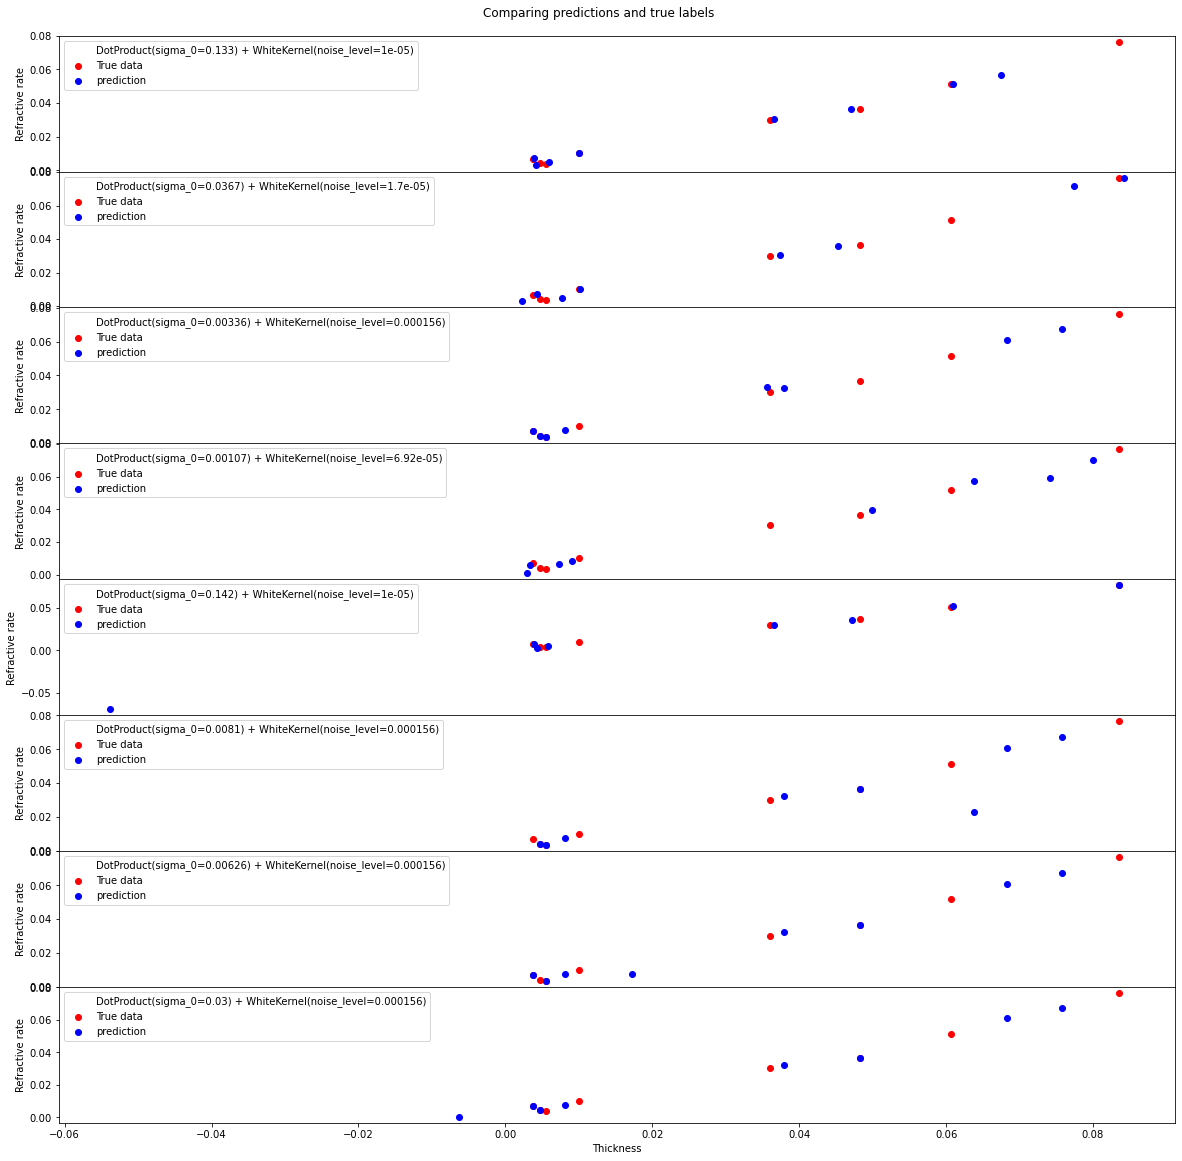

In [8]:
show_plot = True
num_models = len(models["estimator"])
if show_plot:
    fig = plt.figure(figsize=(20,20))
    gs = fig.add_gridspec(len(Y), hspace=0)
    axs = gs.subplots(sharex=True)
    fig.suptitle('Comparing predictions and true labels',y=0.9)
    for estimator, i in zip(models["estimator"],range(num_models)):
        axs[i].scatter(Y[:,0], Y[:,1],label="True data",color="r")
        prediction = estimator.predict(X)
        w = prediction[:,0]
        n = prediction[:,1]
        axs[i].scatter(w,n,label="prediction",color="b")
        axs[i].plot([], [], ' ', label=estimator.kernel_)
        axs[i].legend(loc="upper left")
        axs[i].set_ylabel("Refractive rate")
        
    # Hide x labels and tick labels for all but bottom plot.
    for ax in axs:
        ax.label_outer()
    plt.xlabel("Thickness")